# Day 32 - Teaching notebook for total imaging newbies

https://www.kaggle.com/stkbailey/teaching-notebook-for-total-imaging-newbies

이 커널은 고전적인 이미지 기술을 구현한다. 테스트 이미지에 적용할 수 있는 scipy와 numpy(그리고 약간의 scikit-image)를 사용해 간단한 파이프라인을 개발한다. -- 사실 매개변수를 최적화하는 것 이외엔 train 이미지조차 사용하지 않을 것이다.

In [64]:
import pathlib
import imageio
import numpy as np
import glob

# Glob the training data and load a single image path

#training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
#training_sorted = sorted([x for x in training_paths])
#im_path = training_sorted
#im = imageio.imread(str(im_path))
for image_path in glob.glob('../input/stage1_train/*/images/*.png'):
    im = imageio.imread(image_path)

# Dealing with color

이 데이터셋에서 이미지는 RGB와 RGBA, 얻는 '기준값'을 기준으로 하는 grayscale 형식일 수 있다. 컬러 이미지의 경우 "채널"(빨강, 초록, 파랑 등)을 인코딩하는 세번째 차원이 있다. 이 첫번째 패스에 대해 더 쉽게 하기 위해, scikit-image의 rbg2gray 함수를 사용해 이러한 모든 이미지를 grayscale로 강제 설정할 수 있다.

In [65]:
print('Original image shape : {}'.format(im.shape))

from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape : {}'.format(im_gray.shape))

Original image shape : (360, 360, 4)
New image shape : (360, 360)


<ipython-input-65-00e8e10ee6ef>:4: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray = rgb2gray(im)


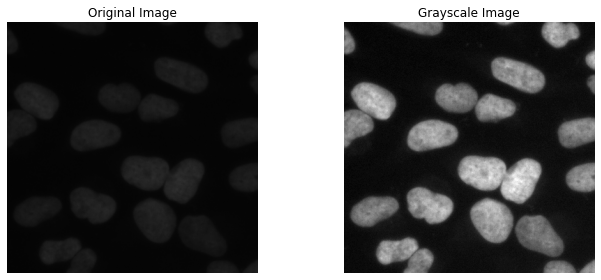

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

# Removing background

아마 이 문제에 대한 가장 간단한 접근법은 이미지에 두 개의 클래스(관심있는 객체와 배경)가 있다고 가정하는 것이다. 이러한 가정 하에서 데이터가 두 가지 종류의 강도 분포에 속할 것으로 예상할 수 있다. 최상의 분리 값을 찾으면 배경 데이터를 "마스킹"한 다음 남은 객체를 셀 수 있다.

임계값을 찾을 수 있는 "가장 비효율적인" 방법은 평균이나 중위수 같은 간단한 기술통계량을 사용하는 것이다. 하지만 다른 방법도 있다. "Otsu" 방법은 이미지를 bimodal 분포로 모델링하고 최적의 분리 값을 찾기 때문에 유용하다.

In [66]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# 마스크의 더 큰 부분이 배경에 고려되도록
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

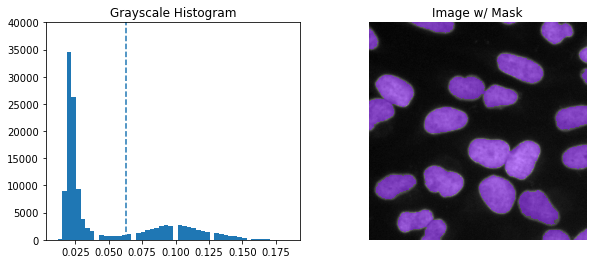

In [42]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels, bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,40000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

# Deriving individual masks for each object

이번 대회에선 핵마다 마스크가 따로 있어야한다. 이 작업을 수행할 수 있는 한 가지 방법은 마스크에 연결된 모든 개체를 찾고 ndimage.label을 사용해 각 개체를 할당하는 것이다. 그리고 각 lable_id를 반복해 리스트와 같은 iterable에 추가할 수 있다.

In [67]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)

label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels==label_num, 1, 0)
    label_arrays.append(label_mask)
    
print('There are {} separate components / objects detected.'.format(nlabels))

There are 24 separate components / objects detected.


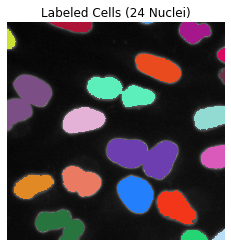

In [44]:
# 랜덤 컬러맵 생성
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels>0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

간단히 살펴보면 다음과 같은 두 문제가 나타난다(이 매우 간단한 이미지에서):
- 독립적인 몇 개의 개별 픽셀 (예: 우측 상단)
- 일부 셀은 단일 마스크로 결합 (예: 상단 중간)

- ndimage.find_objects를 사용해 마스크를 반복할 수 있고, 추가적인 처리 단계를 적용하는 것으로 밝혀진 개별 핵을 확대할 수 있다. find_objects는 이미지에서 각 레이블링된 객체에 대한 좌표 범위 목록을 반환한다.

In [68]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # 레이블 크기가 너무 작은지 확인
    if np.product(cell.shape) < 10:
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)
        
# 레이블 재생성
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 11 is too small! Setting to 0.
Label 18 is too small! Setting to 0.
Label 20 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
There are now 20 separate components / objects detected.


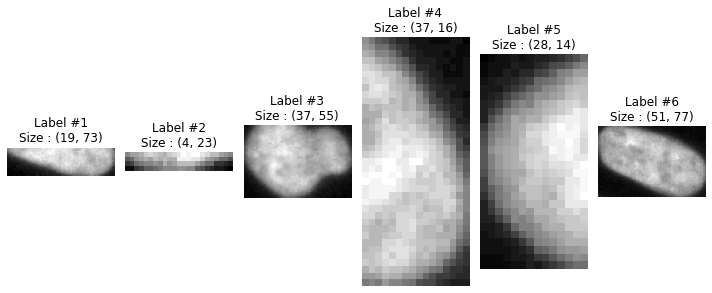

In [46]:
fig, axes = plt.subplots(1, 6, figsize=(10,6))

for ii, obj_indices in enumerate(ndimage.find_objects(labels)[0:6]):
    cell = im_gray[obj_indices]
    axes[ii].imshow(cell, cmap='gray')
    axes[ii].axis('off')
    axes[ii].set_title('Label #{}\nSize : {}'.format(ii+1, cell.shape))
    
plt.tight_layout()
plt.show()

In [69]:
# 개체 인덱스를 얻고, binary opening 절차를 수행
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

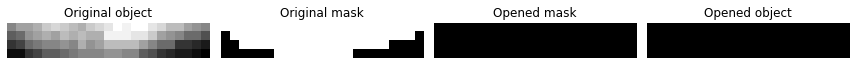

In [70]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Convert each labeled object to Run Line Encoding

마지막으로 각 label_mask를 "run line encoded" 문자열로 인코딩해야한다. 기본적으로 배열을 통해 작업하고, 마스크의 일부인 픽셀을 찾으면 이를 인덱싱하고 마스크의 일부인 후속 픽셀 수를 계산한다. 새로운 픽셀 시작점을 볼 

In [72]:
def rle_encoding(x):
    # x: (높이, 넓이) 크기의 배열, 1:마스크, 0:배경
    # run 길이를 리스트로 반환
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1):
            run_lengths.extend((b+1,0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is : {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is : 103320 1 103674 7 104032 9 104391 10 104749 12 105108 13 105467 14 105826 15 106185 16 106545 16 106904 17 107264 17 107624 17 107984 17 108344 17 108704 17 109064 17 109424 17 109784 17 110144 17 110504 17 110864 17 111224 17 111583 18 111944 17 112304 17 112664 17 113024 17 113384 17 113744 17 114104 17 114465 16 114825 16 115185 16 115547 14 115907 14 116268 13 116628 13 116989 12 117350 11 117710 11 118071 10 118432 9 118793 8 119155 6 119516 5 119879 2


# Combine it into a single function

이제 이미지를 "dump" 방식으로 처리하는 기본 단계를 보았기 때뮨에 모든 것을 한 기능으로 결합할 수 있다. 이 기능은 경로를 선택하고 위에서 설명한 프로세스를 수행한 다음 발견된 각 마스크에 대해 RLE 문자열이 있는 데이터프레임을 표시한다.

또한 데이터셋의 모든 이미지에 대해 단일 DataFrame을 반환하는 wrapper 함수를 생성한다.

In [77]:
import pandas as pd

def analyze_image(im_path):
    #image_path(pathlib.Path object)를 선택하고, 전처리하고 레이블을 지정하고,
    # RLE 문자열을 추출해 Pandas DataFrame에 dump 한다.
    
    # 데이터를 읽고 grayscale로 변환
    #im_id = im_path.parts[-3]
    for image_path in glob.glob(im_path):
        im = imageio.imread(image_path)
    im_gray = rgb2gray(im)
    
    # 배경을 마스킹하고 연결된 개체를 추출
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # 레이블 반복하고 각각 데이터프레임에 추가
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels==label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'EncodePixels':rle})
            im_df = im_df.append(s, ignore_index=True)
            
    return im_df


def analyze_list_of_images(im_path_list):
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [79]:
testing = glob.glob('../input/stage1_test/*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)

<ipython-input-77-cf48540c0d8f>:11: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im_gray = rgb2gray(im)
